# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Luis Antonio Pelayo Sierra

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://a6d68e2ef18e:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/27 18:07:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!ls /opt/spark/work-dir/data/car_service

agencies  brands  cars	car_service.zip  customers  rentals


In [3]:
# Build schemas
# Import your module
from luis_pelayo.spark_utils import SparkUtils
schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])
schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")
df_agencies.show(truncate=False)
df_brands.show(truncate=False)
df_cars.show(truncate=False)
df_customers.show(truncate=False)
df_rentals.show(truncate=False)


+---------+-----------------------------------------------------+
|agency_id|agency_info                                          |
+---------+-----------------------------------------------------+
|1        |{'agency_name': 'NYC Rentals', 'city': 'New York'}   |
|2        |{'agency_name': 'LA Car Rental', 'city': 'Londres'}  |
|3        |{'agency_name': 'Zapopan Auto', 'city': 'Zapopan'}   |
|4        |{'agency_name': 'SF Cars', 'city': 'San Francisco'}  |
|5        |{'agency_name': 'Mexico Cars', 'city': 'Mexico City'}|
+---------+-----------------------------------------------------+

+--------+-----------------------------------------------------+
|brand_id|brand_info                                           |
+--------+-----------------------------------------------------+
|1       |{'brand_name': 'Mercedes-Benz', 'country': 'Germany'}|
|2       |{'brand_name': 'BMW', 'country': 'Germany'}          |
|3       |{'brand_name': 'Audi', 'country': 'Germany'}         |
|4       |{'bra

You need to generate one single dataframe using join operations and extracting columns from the json columns (using get json object) and using only one action. (show())

In [4]:
from pyspark.sql.functions import get_json_object
df_updated_agencies = df_agencies.withColumn("agency_name",get_json_object("agency_info","$.agency_name")) \
                                .withColumn("city",get_json_object("agency_info","$.city")) \
                                .drop("agency_info")
df_updated_agencies.show()

+---------+-------------+-------------+
|agency_id|  agency_name|         city|
+---------+-------------+-------------+
|        1|  NYC Rentals|     New York|
|        2|LA Car Rental|      Londres|
|        3| Zapopan Auto|      Zapopan|
|        4|      SF Cars|San Francisco|
|        5|  Mexico Cars|  Mexico City|
+---------+-------------+-------------+



In [5]:
df_updated_brands = df_brands.withColumn("brand_name",get_json_object("brand_info","$.brand_name")) \
                                .withColumn("country",get_json_object("brand_info","$.country")) \
                                .drop("brand_info")
df_updated_brands.show()

+--------+-------------+-------+
|brand_id|   brand_name|country|
+--------+-------------+-------+
|       1|Mercedes-Benz|Germany|
|       2|          BMW|Germany|
|       3|         Audi|Germany|
|       4|         Ford|     US|
|       5|          BYD|  China|
|       6|        Honda|  Japan|
|       7|       Toyota|  Japan|
+--------+-------------+-------+



In [6]:
df_updated_cars = df_cars.withColumn("car_name",get_json_object("car_info","$.car_name")) \
                            .withColumn("brand_id",get_json_object("car_info","$.brand_id").cast("int")) \
                            .withColumn("price_per_day",get_json_object("car_info","$.price_per_day").cast("int")) \
                            .drop("car_info")
df_updated_cars = df_updated_cars.join(df_updated_brands, df_updated_cars.brand_id == df_updated_brands.brand_id).drop(df_updated_cars.brand_id)
df_updated_cars.show()

+------+--------------------+-------------+--------+-------------+-------+
|car_id|            car_name|price_per_day|brand_id|   brand_name|country|
+------+--------------------+-------------+--------+-------------+-------+
|     1|Chang-Fisher Model 7|          139|       5|          BYD|  China|
|     2|Sheppard-Tucker M...|           70|       6|        Honda|  Japan|
|     3|Faulkner-Howard M...|           53|       3|         Audi|Germany|
|     4|  Wagner LLC Model 1|           89|       5|          BYD|  China|
|     5|  Campos PLC Model 4|          112|       4|         Ford|     US|
|     6|Archer-Patel Model 2|           55|       3|         Audi|Germany|
|     7|Patrick, Barrera ...|           66|       6|        Honda|  Japan|
|     8|Jones, Jefferson ...|          115|       2|          BMW|Germany|
|     9|Garcia, Hamilton ...|          137|       6|        Honda|  Japan|
|    10|  Levy Group Model 9|           93|       3|         Audi|Germany|
|    11|Grimes-Green Mode

In [7]:
df_updated_customers = df_customers.withColumn("customer_name",get_json_object("customer_info","$.customer_name")) \
                                    .withColumn("age",get_json_object("customer_info","$.age").cast("int")) \
                                    .withColumn("city",get_json_object("customer_info","$.city")) \
                                    .drop("customer_info")
df_updated_customers.show()

+-----------+--------------------+---+-------------+
|customer_id|       customer_name|age|         city|
+-----------+--------------------+---+-------------+
|          1|       Tiffany Riley| 32|    Monterrey|
|          2|      Matthew Davies| 36|    Monterrey|
|          3|      Rebecca Miller| 30|  Mexico City|
|          4|       Katelyn Mccoy| 34|     New York|
|          5|         Dana Dennis| 26|      Zapopan|
|          6|       Daniel Norton| 34|  Mexico City|
|          7|       Robert Garcia| 47|      Zapopan|
|          8|    Michael Williams| 33|    Monterrey|
|          9|      Susan Ferguson| 41|San Francisco|
|         10|         Alyssa Reid| 40|  Mexico City|
|         11|         Laura Myers| 50|      Zapopan|
|         12|     William Johnson| 25|    Monterrey|
|         13|         Tyler Lopez| 21|  Mexico City|
|         14|         Daniel Owen| 47|  Mexico City|
|         15|     Allison Coleman| 33|      Zapopan|
|         16|        David Walker| 33|      Lo

In [8]:
df_updated_rentals = df_rentals.withColumn("car_id", get_json_object(df_rentals.rental_info, "$.car_id")) \
                .withColumn("customer_id", get_json_object(df_rentals.rental_info, "$.customer_id")) \
                .withColumn("agency_id", get_json_object(df_rentals.rental_info, "$.agency_id")) \
                .drop("rental_info")
df_updated_rentals.show()

+---------+------+-----------+---------+
|rental_id|car_id|customer_id|agency_id|
+---------+------+-----------+---------+
|    11891|    21|         71|        1|
|    11892|    11|         52|        2|
|    11893|    22|        116|        4|
|    11894|     5|        107|        1|
|    11895|     4|         53|        4|
|    11896|     8|        131|        2|
|    11897|    23|         66|        3|
|    11898|    24|         60|        4|
|    11899|    27|         92|        2|
|    11900|     3|         40|        4|
|    11901|     3|         35|        1|
|    11902|     3|         72|        1|
|    11903|    29|         58|        3|
|    11904|     3|        131|        4|
|    11905|    27|         10|        2|
|    11906|    12|         40|        1|
|    11907|    25|         53|        3|
|    11908|    14|        153|        4|
|    11909|    24|         96|        4|
|    11910|    24|        151|        4|
+---------+------+-----------+---------+
only showing top

In [9]:
df = df_updated_rentals.join(df_updated_cars, df_updated_rentals.car_id == df_updated_cars.car_id).drop(df_updated_rentals.car_id)
df = df.join(df_updated_customers, df.customer_id == df_updated_customers.customer_id).drop(df.customer_id)
df = df.join(df_updated_agencies, df.agency_id == df_updated_agencies.agency_id).drop(df.agency_id)
df.show()

+---------+------+--------------------+-------------+--------+----------+-------+-----------+-----------------+---+-------------+---------+-------------+-------------+
|rental_id|car_id|            car_name|price_per_day|brand_id|brand_name|country|customer_id|    customer_name|age|         city|agency_id|  agency_name|         city|
+---------+------+--------------------+-------------+--------+----------+-------+-----------+-----------------+---+-------------+---------+-------------+-------------+
|      785|     1|Chang-Fisher Model 7|          139|       5|       BYD|  China|         33|       Corey Cook| 35|    Monterrey|        4|      SF Cars|San Francisco|
|      766|     1|Chang-Fisher Model 7|          139|       5|       BYD|  China|         96|    Laura Gregory| 25|      Londres|        2|LA Car Rental|      Londres|
|      762|     1|Chang-Fisher Model 7|          139|       5|       BYD|  China|        149|      Blake Jones| 25|  Mexico City|        3| Zapopan Auto|      Z

# Solucion, un unico show() que muestre rental_id, car_name, customer_name y agency_name

In [10]:
df.select("rental_id","car_name","customer_name","agency_name").show()

+---------+--------------------+-----------------+-------------+
|rental_id|            car_name|    customer_name|  agency_name|
+---------+--------------------+-----------------+-------------+
|      785|Chang-Fisher Model 7|       Corey Cook|      SF Cars|
|      766|Chang-Fisher Model 7|    Laura Gregory|LA Car Rental|
|      762|Chang-Fisher Model 7|      Blake Jones| Zapopan Auto|
|      757|Chang-Fisher Model 7|   Nicholas Kline|  NYC Rentals|
|      747|Chang-Fisher Model 7|    Melissa Flynn|LA Car Rental|
|      735|Chang-Fisher Model 7|     Joseph Jones|  NYC Rentals|
|      672|Chang-Fisher Model 7|    Melissa Flynn|      SF Cars|
|      669|Chang-Fisher Model 7|   Susan Ferguson|      SF Cars|
|      662|Chang-Fisher Model 7|  Raymond Navarro|LA Car Rental|
|      654|Chang-Fisher Model 7|   Sherry Simpson|LA Car Rental|
|      617|Chang-Fisher Model 7| Jenny Richardson|LA Car Rental|
|      615|Chang-Fisher Model 7|  Jennifer Torres|LA Car Rental|
|      591|Chang-Fisher M

# Parquet file

In [37]:
!pwd

/opt/spark/work-dir/labs/lab04


In [61]:
path = "/opt/spark/work-dir/data/"

In [44]:
df_final = df.select("rental_id","car_name","customer_name","agency_name")
df_final.write.partitionBy("agency_name") \
                .mode("overwrite") \
                .parquet(path + "car_service/output/parquet")

In [45]:
!ls

artifacts  lab04_luis_pelayo.ipynb  lab04_template.ipynb  opt


In [46]:
!ls ../../data/car_service/output/parquet

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [47]:
!du -sh ../../data/car_service/output/parquet

112K	../../data/car_service/output/parquet


# CSV

In [62]:
df_final.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(path + "car_service/output/csv")

In [63]:
!ls ../../data/car_service/output/csv

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [64]:
!du -sh ../../data/car_service/output/csv

832K	../../data/car_service/output/csv


# Power BI

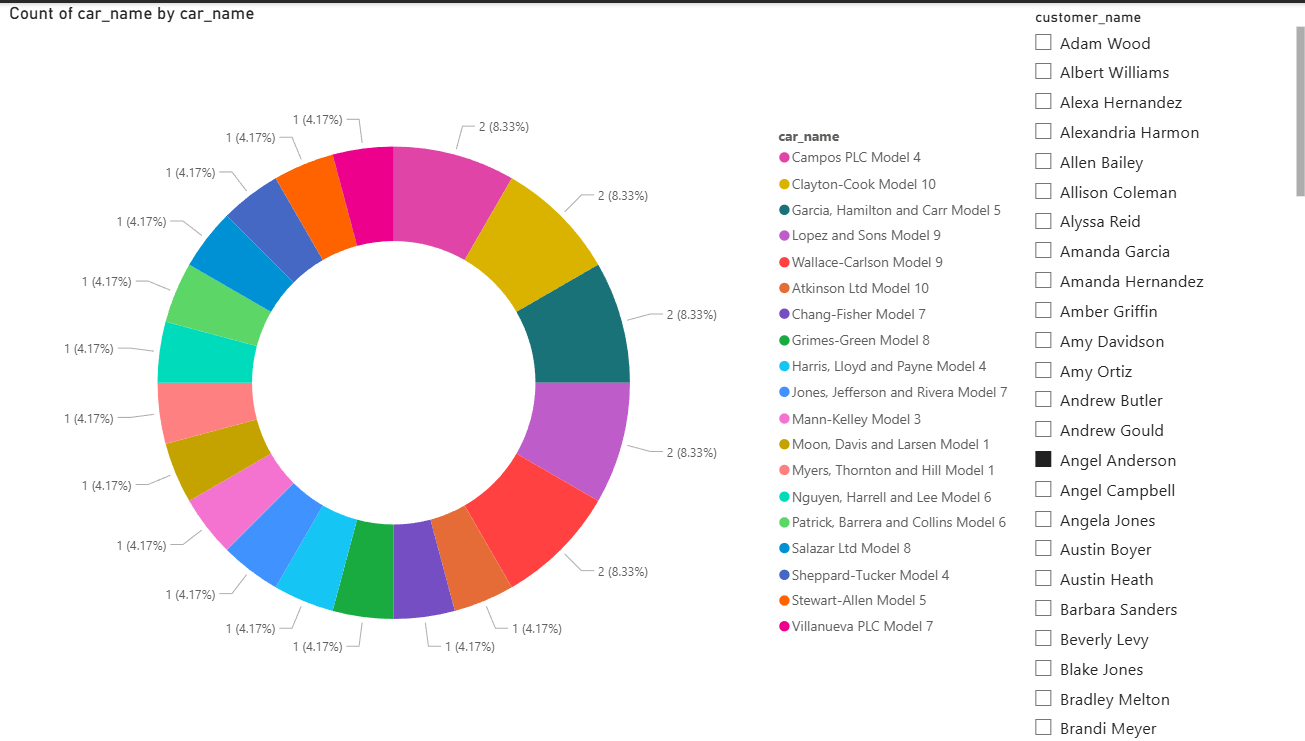

In [ ]:
sc.stop()